# Simulating Stock Price Developement

## Theory

The price of today is the price of yesterday times its daily return. Since we will use log returns for the simulation, to get the real return, we need to calculate e to the power of the logarithmic return.

$
Price_{t} = Price_{t-1} * e^{r}
$

Yesterday's stock price is known, but r is a random variable. The brownian motion allows us to model that randomness. It consists of the addition of two components, the drift (approximation of future. Expected daily return of stock) and the stock's volatility (shock).

$
drift = u - \frac{1}{2} \cdot var
$

Z corresponds to the distance between the data point and its mean within a standard normal distribution (Number of standard deviations).

$
shock = std * Z[Rand(0;1)]
$

Therefore today's price will be:

$
Price_{t} = Price_{t-1} * e^{(u - \frac{1}{2} \cdot var) + std * Z[Rand(0;1)]}
$

## Import libraries

In [30]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
np.set_printoptions(threshold=5)

## Parameters

In [31]:
stock = 'F' # Indicate the symbol of the stock you want to simulate
t_intervals = 1000 # Simulation period in number of days
iterations = 10 # series of simulations
scenario = 'recession' # type 'recession' or 'boom' for different market scenarios
certainty = 0.95 # Certainty of Confidence Interval

## Fetch historical stock price data

In [32]:
data = pd.DataFrame() # Create empty data frame

# start indicates the earliest date of historical prices on yahoo 
data[stock] = wb.DataReader(stock, data_source='yahoo', start='2010-06-29')['Adj Close'] # fetch data from yahoo

In [33]:
data.tail()

,F
Date,
2022-10-17,11.83
2022-10-18,12.03
2022-10-19,12.13
2022-10-20,11.77
2022-10-21,12.19


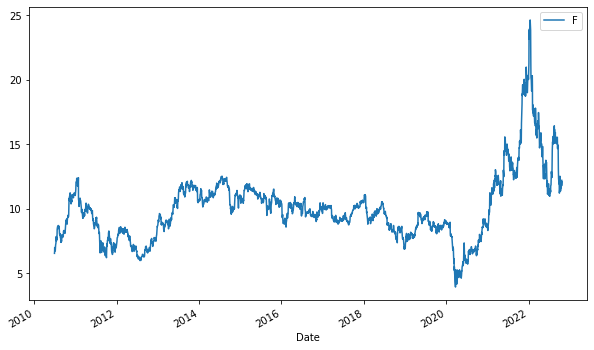

In [34]:
# Stock price developement
data.plot(figsize=(10, 6));

## Transform price data into daily returns

Share returns are continuous. Therefore we ned to take the natural logarithm. Arithmetic returns are discrete, not compounded and computed only for one single period. Since logarithmic returns are continuously compounded between the periods, the returns can be added. If we want to model retruns, we need to use the normal distribution. We cannot use simple returns, because they are not normally distributed. Log returns however, do follow a normal distribution. Log returns are symmetric and returns of equal magnitude but opposite signs will cancel each other out. Arithmetic return has a positive bias. To eliminate this bias we need to take the log return. 

In [35]:
log_returns = np.log(1+data.pct_change()) # calculate log returns

In [36]:
log_returns.tail()

,F
Date,
2022-10-17,0.013617
2022-10-18,0.016765
2022-10-19,0.008278
2022-10-20,-0.030128
2022-10-21,0.035062


<AxesSubplot:xlabel='Date'>

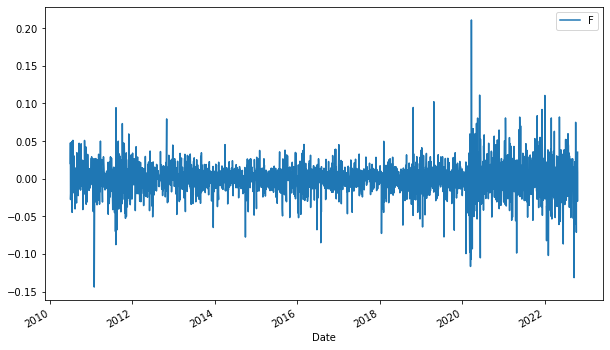

In [37]:
# Distribution of log returns
log_returns.plot(figsize=(10,6))

## Calculate drift

In [38]:
u = log_returns.mean()
u

F    0.000202
dtype: float64

In [39]:
var = log_returns.var()
var

F    0.000444
dtype: float64

In [40]:
drift = u - (0.5*var)
drift

F   -0.00002
dtype: float64

## Calculate shock

In [41]:
std = log_returns.std()
std

F    0.021062
dtype: float64

In [42]:
# The number of standard deviations from the mean, based on a random probability
Z = norm.ppf(np.random.rand(t_intervals, iterations))
Z

array([[ 1.89106666,  0.17992924,  0.55693345, ...,  0.44887619,
         0.20578976, -2.16778242],
       [ 0.35410157,  1.47982759, -0.99698644, ..., -0.75601099,
        -0.02432882, -0.99255719],
       [-0.26836227,  0.03300876,  0.08951623, ..., -0.69034051,
         0.53764134, -0.55934098],
       ...,
       [-0.82548793, -1.61889947,  0.24583532, ...,  0.6033967 ,
         0.53075974,  1.00599796],
       [-0.65827202,  0.24049219, -0.45674821, ...,  0.76334281,
        -0.36073181,  0.56233287],
       [-1.25233208, -2.5480418 , -1.91362765, ...,  1.40272564,
         0.33922686, -0.59242754]])

In [43]:
shock = std.values * Z
shock

array([[ 0.03982933,  0.00378964,  0.01173004, ...,  0.00945416,
         0.00433431, -0.04565747],
       [ 0.00745803,  0.03116788, -0.02099836, ..., -0.01592298,
        -0.00051241, -0.02090507],
       [-0.0056522 ,  0.00069522,  0.00188538, ..., -0.01453984,
         0.01132371, -0.01178075],
       ...,
       [-0.01738629, -0.03409699,  0.00517774, ...,  0.01270864,
         0.01117877,  0.02118816],
       [-0.01386441,  0.00506521, -0.00961995, ...,  0.0160774 ,
        -0.00759767,  0.01184376],
       [-0.02637641, -0.05366643, -0.0403045 , ...,  0.02954397,
         0.00714474, -0.01247761]])

## Calculate daily returns

In [44]:
# Computing random variable r
r = drift.values + shock
r

array([[ 0.03980927,  0.00376958,  0.01170998, ...,  0.0094341 ,
         0.00431425, -0.04567753],
       [ 0.00743797,  0.03114782, -0.02101842, ..., -0.01594303,
        -0.00053247, -0.02092513],
       [-0.00567226,  0.00067517,  0.00186532, ..., -0.01455989,
         0.01130365, -0.0118008 ],
       ...,
       [-0.01740635, -0.03411705,  0.00515768, ...,  0.01268858,
         0.01115871,  0.0211681 ],
       [-0.01388447,  0.00504515, -0.00964001, ...,  0.01605734,
        -0.00761773,  0.0118237 ],
       [-0.02639647, -0.05368649, -0.04032456, ...,  0.02952391,
         0.00712468, -0.01249767]])

In [45]:
# Computing daily returns
daily_returns = np.exp(r)
daily_returns

array([[1.04061228, 1.0037767 , 1.01177881, ..., 1.00947874, 1.00432357,
        0.95534999],
       [1.0074657 , 1.03163799, 0.97920093, ..., 0.98418338, 0.99946767,
        0.97929228],
       [0.9943438 , 1.0006754 , 1.00186706, ..., 0.98554559, 1.01136778,
        0.98826855],
       ...,
       [0.98274427, 0.96645838, 1.00517101, ..., 1.01276942, 1.01122121,
        1.02139374],
       [0.98621147, 1.0050579 , 0.9904063 , ..., 1.01618695, 0.99241121,
        1.01189388],
       [0.97394888, 0.94772919, 0.96047765, ..., 1.02996407, 1.00715012,
        0.9875801 ]])

## Simulate stock growth

In [46]:
# Most recent stock price
S0 = data.iloc[-1]
S0

F    12.19
Name: 2022-10-21 00:00:00, dtype: float64

In [47]:
# Create empty price data frame as big as the daily returns df
price_list = np.zeros_like(daily_returns)

In [48]:
price_list

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
# Set most recent price as starting point for each iteration
price_list[0] = S0

In [50]:
# Replace 0's with expected stock prices
for t in range(1, t_intervals):
    price_list[t] = price_list[t-1]*daily_returns[t]

In [51]:
price_list

array([[12.18999958, 12.18999958, 12.18999958, ..., 12.18999958,
        12.18999958, 12.18999958],
       [12.28100646, 12.57566668, 11.93645891, ..., 11.99719502,
        12.18351053, 11.93757249],
       [12.21154261, 12.58416023, 11.95874498, ..., 11.82378264,
        12.32201001, 11.79752749],
       ...,
       [22.63690694, 22.46464454, 13.9123242 , ...,  3.39548348,
         9.03649792,  2.66837071],
       [22.32477732, 22.57826838, 13.77885359, ...,  3.45044601,
         8.96792184,  2.70010799],
       [21.74319177, 21.39808391, 13.23428097, ...,  3.5538354 ,
         9.03204357,  2.66657293]])

## Confidence Interval and Expected Return

Calculate confidence interval [1.96 and -1.96 standard deviation of its mean] with 95% certainty

In [52]:
# Python includes the left/lower-tail probability by default, therefore we need to take this into account, 
# when computing the standard deviation multiplier
std_multiplier_high = norm.ppf(1-((1 - certainty)/2))
std_multiplier_low = norm.ppf((1 - certainty)/2)

In [53]:
# Computing returns for upper and lower price bounds
returns_high = np.zeros(t_intervals) 
returns_low = np.zeros(t_intervals)

for t in range(1, t_intervals):
    returns_high[t] = drift*t + std*std_multiplier_high*np.sqrt(t)
    returns_low[t] = drift*t + std*std_multiplier_low*np.sqrt(t)

In [54]:
# Computing upper and lower price bounds
interval_high = np.zeros_like(returns_high)
interval_low = np.zeros_like(returns_low)
interval_high[0] = S0 
interval_low[0] = S0 

for t in range(1, t_intervals):
    interval_high[t] = S0 * np.exp(returns_high[t])
    interval_low[t] = S0 * np.exp(returns_low[t])

In [55]:
# Expected Price Growth
exp_price = np.zeros(t_intervals)
exp_price[0] = S0

for t in range(1, t_intervals):
    exp_price[t] = exp_price[t-1]*np.exp(u)

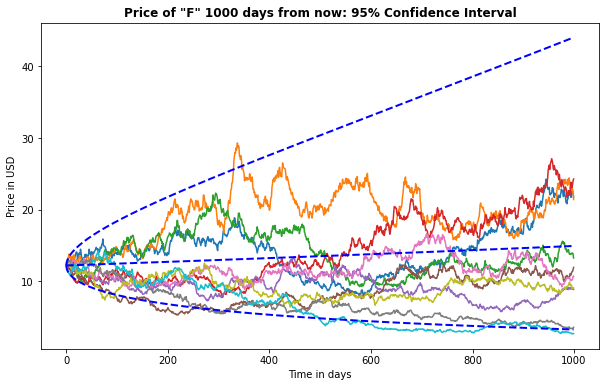

In [56]:
plt.figure(figsize=(10,6))
plt.plot(price_list);
plt.plot(exp_price, linewidth=2, linestyle='--', color='blue');
plt.plot(interval_high, linewidth=2, linestyle='--', color='blue');
plt.plot(interval_low, linewidth=2, linestyle='--', color='blue');
plt.title('Price of "'+stock+'" '+str(t_intervals)+' days from now: '+"{0:.0%}".format(certainty)+' Confidence Interval', fontweight = "bold")
plt.xlabel('Time in days')
plt.ylabel('Price in USD')
plt.show()

In [57]:
# Upper Bound Price at end of period
interval_high[-1]

44.050073796051635

In [58]:
# Lower Bound Price at end of period
interval_low[-1]

3.240828408832743